In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
df=pd.read_csv('Test_data.csv')

In [81]:
df.head()

,id,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,year,duration-min
0,4943,0.03360,0.523,0.861,No,0.000000,0,0.1440,-3.447,Major,01-01-2014,0.0644,127.049,0.346,2014,3.8
1,16165,0.76500,0.687,0.453,No,0.000008,7,0.0897,-11.649,Major,01-04-1972,0.0335,129.987,0.830,1972,3.8
2,6774,0.36300,0.536,0.640,No,0.000000,0,0.0948,-5.862,Major,02-06-1998,0.0368,142.483,0.289,1998,4.4
3,9959,0.00463,0.890,0.617,No,0.003850,2,0.0291,-12.096,Minor,08-09-1980,0.0418,121.126,0.970,1980,3.9
4,13818,0.00187,0.555,0.943,No,0.000042,2,0.1510,-2.492,Major,17-04-2007,0.0891,165.026,0.882,2007,3.2


In [82]:
df.shape

(4000, 16)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4000 non-null   int64  
 1   acousticness      4000 non-null   float64
 2   danceability      4000 non-null   float64
 3   energy            4000 non-null   float64
 4   explicit          4000 non-null   object 
 5   instrumentalness  4000 non-null   float64
 6   key               4000 non-null   int64  
 7   liveness          4000 non-null   float64
 8   loudness          4000 non-null   float64
 9   mode              4000 non-null   object 
 10  release_date      4000 non-null   object 
 11  speechiness       4000 non-null   float64
 12  tempo             4000 non-null   float64
 13  valence           4000 non-null   float64
 14  year              4000 non-null   int64  
 15  duration-min      4000 non-null   float64
dtypes: float64(10), int64(3), object(3)
memory

In [84]:
continuous_feature=['acousticness', 'danceability', 'energy','instrumentalness','key','liveness','speechiness','tempo', 'valence']

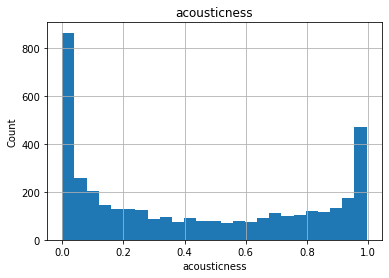

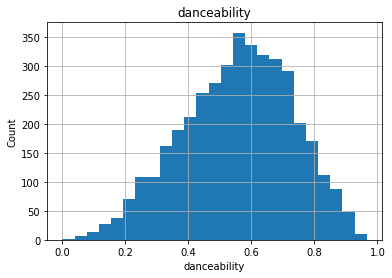

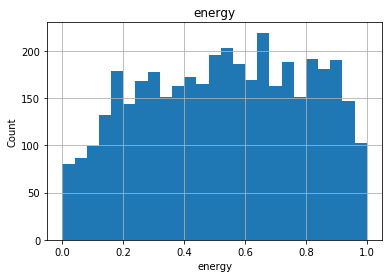

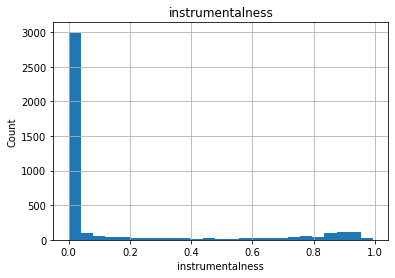

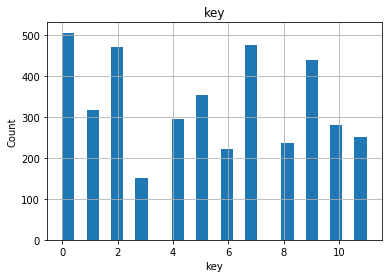

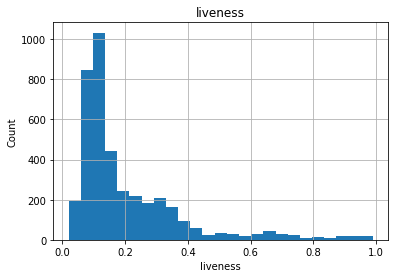

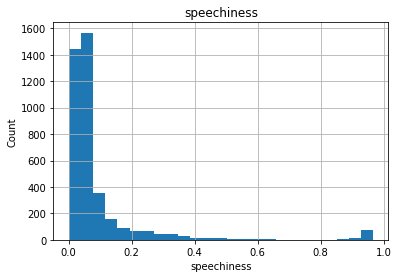

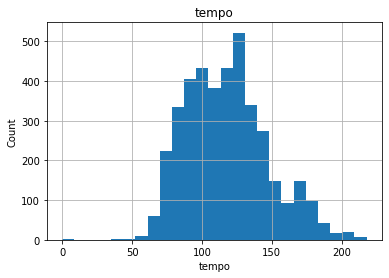

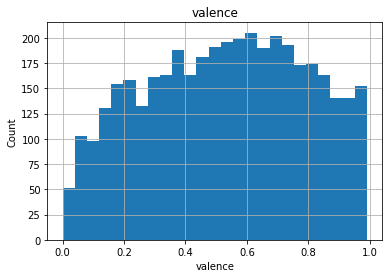

In [85]:
for feature in continuous_feature:
    data1=df.copy()
    data1[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [86]:
df=df.drop(columns='release_date')

In [87]:
df['year']=df['year']-1920

In [88]:
df['tempo']=np.where(df['tempo']== 0, df['tempo'], df['tempo'].median())

In [89]:
from sklearn.preprocessing import minmax_scale

df[['tempo','year','loudness','duration-min']] = minmax_scale(df[['tempo','year','loudness','duration-min']])

In [90]:
def category_onehot_multcols(multcolumns):
    df_final=df
    i=0
    for fields in multcolumns:
        
        print(fields)
        df1=pd.get_dummies(df[fields],drop_first=True)
        
        df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([df,df_final],axis=1)
        
    return df_final

In [91]:
categorical_features=['explicit','mode']

In [92]:
df=category_onehot_multcols(categorical_features)

explicit
mode


In [93]:
df_train=pd.read_csv('final_train.csv')

In [94]:
X = df_train.drop(columns=['popularity','id'])
Y = df_train['popularity']

In [95]:
data=df.copy()
data=data.drop(columns='id')

In [96]:
from xgboost import XGBClassifier

In [97]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [98]:
y_pred=xgb_clf.predict(data)

In [99]:
y_pred

array([4, 2, 3, ..., 3, 1, 4], dtype=int64)

In [100]:
pred=pd.DataFrame(y_pred)
#sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([df['id'],pred],axis=1)
datasets.columns=['id','popularity']
#datasets.to_csv('submission.csv',index=False)

In [101]:
datasets

,id,popularity
0,4943,4
1,16165,2
2,6774,3
3,9959,2
4,13818,3
...,...,...
3995,6367,2
3996,12061,4
3997,15802,3
3998,11746,1


In [102]:
datasets['popularity']=datasets.popularity.map({
    1:"very low", 2:"low", 3:"average", 4:"high", 5:'very high'
})

In [103]:
datasets

,id,popularity
0,4943,high
1,16165,low
2,6774,average
3,9959,low
4,13818,average
...,...,...
3995,6367,low
3996,12061,high
3997,15802,average
3998,11746,very low


In [104]:
datasets.to_csv('submission.csv',index=False)